# Genetic Application: Prostate

## Intro

- We consider $n$ samples for **few-shot learning**
- The matrix $\mathbf{X}$ now consists of $n$ samples of size $p = 7129$, with $n << p$.
- The vector $\mathbf{y}$ consists of the $n$ labels of $\mathbf{X}$ (i.e. $y_i \in \{-1, +1\}$ for all $i = 1,\dots,n$)
- We consider the following **feature selection** task: learn a **sparse set of explainable features** (i.e. pixels) $\boldsymbol{\hat \beta}$ from which a small set of training samples samples $\mathbf{X}, \mathbf{y}$ can be classified as gppd as possible. Formally,

\begin{eqnarray}
\text{minimize}_{\boldsymbol{\beta} \in \mathbb{B}^p} && \| \mathbf{X} \boldsymbol{\beta} - \mathbf{y} \|^2_2 \\
\text{subject to} && \| \boldsymbol{\beta} \|_1 \leq \eta
\end{eqnarray}

where $\mathbf{X} \in \mathbb{R}^{n \times p}$ and $\mathbf{y} \in \{-1, +1\}^{n}$ are the few training samples and labels, respectively (with $n << p$), and $\eta$ is the number of explainable features to be selected.

## Librairies

In [1]:
# !pip install deeplake
# !pip install -U scikit-learn

# !pip install fcbf
# # https://github.com/m-martin-j/fcbf

In [2]:
import os

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import pickle

import pandas as pd
import numpy as np
import scipy.io

#import deeplake
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold

from fcbf import fcbf, data
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, r_regression, chi2

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA, SparsePCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

from utils.utils import *
from utils.models import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
%load_ext autoreload
%autoreload 2

## Load data

In [4]:
Prostate_data = fetch_openml(name = 'Prostate', version = 1, as_frame = True, parser = 'auto')
data = Prostate_data.data 
y = Prostate_data.target

In [5]:
# Cast data
data = np.array(data)  # Conversion de data en numpy array
y = np.array(y)        # Conversion de y en numpy array

In [6]:
# Suffle data
np.random.seed(12)

indices = np.random.choice(y.shape[0], size=y.shape[0], replace=False)
data = data[indices]
y = y[indices]

In [7]:
data.shape, y.shape

((102, 12600), (102,))

## Parameters

In [102]:
# nb_fts = 158    # 1.25%
# nb_fts = 315    # 2.50%
# b_fts = 630    # 5%
nb_fts = 1260   # 10%

In [103]:
results_folder = f"results/genetic_data_Prostate/{nb_fts}" # separate folder for any nb_fts

if not os.path.exists(results_folder):
    os.mkdir(results_folder)

In [104]:
# Choose your models

models_l = ["knn", 
            "lr", 
            "svc", 
            "nb-gaussian", 
            ### "nb-bernouilli", 
            ### "nb-categorical",
            ### "rf"
           ]

# Choose your feature selection methods
fts_modes_l = ["full", 
               "random", 
               "k-best", 
               "k-best-mi",     # new 
               ###"pca", 
               "sparse-pca", 
               ###"lfs", 
               ###"lbs", 
               ###"fcbf"        # do it one time, since always the same
              ]

## Ten times 10-fold cross validation

In [105]:
def get_CV_splits(seed=42):

    cv_d = {"train_splits": [], "test_splits": []}

    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    kf.get_n_splits(data)

    for train_index, test_index in kf.split(data):

        cv_d["train_splits"].append(train_index)
        cv_d["test_splits"].append(test_index)
        
    return cv_d

In [106]:
cv_d = get_CV_splits(seed=42)
# cv_d

In [107]:
# 10 times 10-fold CV

cv_splits_all = []

for seed in tqdm([33, 42, 1, 5, 1979, 2024, 22, 12, 1996, 11]):
    
    cv_d = get_CV_splits(seed=seed)
    
    cv_splits_all.append(cv_d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2291.97it/s]


In [108]:
# cv_splits_all

In [86]:
# *** new function ***
def select_features(train_indices, test_indices, data=data, y=y, norm=True, fts_mode="full"):
        
    # 2. fts selection
    if fts_mode == "random":
        rand_ind = np.random.randint(low=0, high=data.shape[1], size=nb_fts, dtype=int)
        current_data = data[:, rand_ind]
        
    else:
        current_data = data

    # 2. split
    # train set
    X_train_split = current_data[train_indices, :]
    if norm:
        X_train_split = normalize(X_train_split, axis=0)
    y_train_split = y[train_indices]

    label_encoder = LabelEncoder()
    y_train_split = label_encoder.fit_transform(y_train_split)
    y_train_split = 2 * y_train_split - 1

    # test set
    X_test_split = current_data[test_indices, :]
    if norm:
        X_test_split = normalize(X_test_split, axis=0)
    y_test_split = y[test_indices]
    y_test_split = label_encoder.transform(y_test_split)
    y_test_split = 2 * y_test_split - 1

    if fts_mode == "pca": # unsupervised
        pca = PCA(n_components=min(nb_fts, len(X_train_split))) # PCA limited by nb of rows of X (64)
        X_train_split = pca.fit_transform(X_train_split)
        X_test_split = pca.transform(X_test_split)

    if fts_mode == "sparse-pca": # unsupervised
        sparse_pca = SparsePCA(n_components=nb_fts, alpha=0.5, tol=1e-4, verbose=False)
        X_train_split = sparse_pca.fit_transform(X_train_split)
        X_test_split = sparse_pca.transform(X_test_split)

    if fts_mode == "lfs": # supervised
        # Note that the model used in the LFS algo and the downstream classifier (current_model) are the same!
        lfs = SequentialFeatureSelector(current_model, n_features_to_select=nb_fts, direction="forward")
        X_train_split = lfs.fit_transform(X_train_split, y_train_split)
        X_test_split = lfs.transform(X_test_split)

    if fts_mode == "lbs": # supervised
        # Note that the model used in the LFS algo and the downstream classifier (current_model) are the same!
        lfs = SequentialFeatureSelector(current_model, n_features_to_select=nb_fts, direction="backward")
        X_train_split = lfs.fit_transform(X_train_split, y_train_split)
        X_test_split = lfs.transform(X_test_split)

    if fts_mode == "k-best": # supervised
        # k_best = SelectKBest(chi2, k=nb_fts)
        k_best = SelectKBest(f_classif, k=nb_fts)
        X_train_split = k_best.fit_transform(X_train_split, y_train_split)
        X_test_split = k_best.transform(X_test_split) # no y here!

    if fts_mode == "k-best-mi": # supervised
        k_best = SelectKBest(mutual_info_classif, k=nb_fts)
        X_train_split = k_best.fit_transform(X_train_split, y_train_split)
        X_test_split = k_best.transform(X_test_split) # no y here!

    if fts_mode == "fcbf": # supervised XXX
        X_train_split_df = pd.DataFrame(X_train_split)
        X_test_split_df = pd.DataFrame(X_test_split)
        y_train_split_df = pd.Series(y_train_split).astype(int)

        nb_cols = X_train
        _split.shape[1] + 1
        dataset = pd.concat([X_train_split_df, y_train_split_df], axis=1)
        dataset.columns = list(range(nb_cols))
        X_train_split_df = dataset.iloc[:, :-1]
        y_train_split_df = dataset.iloc[:, -1].astype(int)
        
        fts_ind, _, _ = fcbf(X_train_split_df, y_train_split_df, su_threshold=0.1, base=2)
        print("Selected features", fts_ind)       # only one feature selected whatever the threshold???
        X_train_split = X_train_split[:, fts_ind]
        X_test_split = X_test_split[:, fts_ind]

    return X_train_split, y_train_split, X_test_split, y_test_split

In [87]:
# *** new function ***
def fit_model(X_train_split, y_train_split, X_test_split, y_test_split, model="knn"):

    # 1. model
    if model == "knn":
        current_model = KNeighborsClassifier()
    elif model == "lr":
        current_model = LogisticRegression()
    elif model == "svc":
        current_model = SVC()
    elif model == "nb-gaussian":
        current_model = GaussianNB()
    elif model == "nb-complement":
        current_model = ComplementNB()
    elif model == "nb-bernouilli":
        current_model = BernoulliNB()
    elif model == "nb-categorical":
        current_model = CategoricalNB()
    elif model == "rf":
        current_model = RandomForestClassifier()
    
    current_model.fit(X_train_split, y_train_split)
    y_test_preds = current_model.predict(X_test_split)

    # results
    # report = classification_report(y_test_split, y_test_preds)
    f1 = f1_score(y_test_split, y_test_preds, average='macro')
    b_acc = balanced_accuracy_score(y_test_split, y_test_preds)
        
    return f1, b_acc

## All experiments except Pk-LPNN at once

> - The following cell runs all feature selection modes (`fts_modes_l`) and all dowstream models (`models_l`).
> 
> - The results are then saved in `results_folder/`.
>
> - Hence, the individual sections (Full features, Random features, etc.) do not need to be executed anymore.

In [57]:
# *** new loop ***
# 10 times 10-fold CV: 100 experiments

results_all_d = {}

# 1. loop over feat modes:
for fts_mode in fts_modes_l:
        
    results_all_d[fts_mode] = {}

    # 2. 10 times 10-fold CV: 100 experiments
    for cv_d in tqdm(cv_splits_all):
        for train_indices, test_indices in zip(cv_d["train_splits"], cv_d["test_splits"]):
        
            X_train_split, y_train_split, X_test_split, y_test_split = select_features(train_indices, 
                                                                                       test_indices,
                                                                                       data=data, 
                                                                                       y=y, 
                                                                                       norm=True, 
                                                                                       fts_mode=fts_mode)
        
        
            # 3. loop over models
            for model in models_l:
    
                if model not in results_all_d[fts_mode].keys():
                    results_all_d[fts_mode][model] = {"f1" : [], "b_acc" : []}
                
                f1, b_acc = fit_model(X_train_split, 
                                      y_train_split, 
                                      X_test_split, 
                                      y_test_split, 
                                      model=model)
                
                results_all_d[fts_mode][model]["f1"].append(f1)
                results_all_d[fts_mode][model]["b_acc"].append(b_acc)

    # save all results for fts_mode
    for model in models_l:
        
        with open(os.path.join(results_folder, f"{fts_mode}_{nb_fts}_{model}.pkl"), "wb") as fh:
            pickle.dump(results_all_d[fts_mode][model], fh)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [45:58:40<00:00, 16552.02s/it]


In [58]:
for fts_mode in fts_modes_l:

    for model in models_l:
        print("*"*60)
        
        scores_full_fts = results_all_d[fts_mode][model]
    
        print(f"*** Features mode: {fts_mode} - Model: {model} ***")
        print(f"""Test: macro F1 (mean, std): \t\t{np.mean(scores_full_fts["f1"])}""")
        print(f"""Test: balanced accuracy (mean, std): \t{np.mean(scores_full_fts["b_acc"])}""")

************************************************************
*** Features mode: full - Model: knn ***
Test: macro F1 (mean, std): 		0.7460618140029903
Test: balanced accuracy (mean, std): 	0.7768869047619049
************************************************************
*** Features mode: full - Model: lr ***
Test: macro F1 (mean, std): 		0.6814772686463861
Test: balanced accuracy (mean, std): 	0.7343749999999999
************************************************************
*** Features mode: full - Model: svc ***
Test: macro F1 (mean, std): 		0.322614103131131
Test: balanced accuracy (mean, std): 	0.5
************************************************************
*** Features mode: full - Model: nb-gaussian ***
Test: macro F1 (mean, std): 		0.3516757996045922
Test: balanced accuracy (mean, std): 	0.5154285714285715
************************************************************
*** Features mode: random - Model: knn ***
Test: macro F1 (mean, std): 		0.7348781357531357
Test: balanced accuracy 

> STOP HERE!

## Pk-LPNN-selected features (normalized)

> - This is the code for the Pk-LPNN experiments.

In [109]:
# Repeat 10 times:
#   10-fold CV
#   train PK-LPNN on 9 folds                     -> Nz selected fts
#   test PK-LPNN on 1 fold (KNN + selected fts)  -> b_acc, F1-score

In [110]:
def LPNN_experiment(p, Nz, k, mu_0=0.5, train_indices=None):

    # 1. split
    # train set
    X = data[train_indices, :]
    X = normalize(X, axis=0)

    label_encoder = LabelEncoder()
    Y = y[train_indices]
    Y = label_encoder.fit_transform(Y)
    Y = 2 * Y - 1

    # 2. Initialization
    beta_0, mu_0 = beta_0_and_mu_0(p=p, Nz=Nz, k=k, mu_0=mu_0, method="Pk-LPNN_v2")
    # check_conditions(beta, X, beta_0, n, Nz, k, method=method)

    # 3. dynamical system
    z0 = np.hstack([beta_0, mu_0])
    t_span = (0, 15) # (0, 300) # here
    t = t_span[1]
    eta = Nz

    # with tqdm() as pbar: # too much printing
        
    sol = solve_ivp(LPNN, 
                    t_span=t_span, 
                    y0=z0, 
                    args=(X, Y, eta, k, "Pk-LPNN_v2"), #, pbar), 
                    method="RK45", # DOP853, RK45
                    dense_output=False, 
                    max_step=0.1, 
                    atol=1.2e-4, 
                    rtol=1e-4)

    beta_sol = sol["y"][:-1, -1]
    mu_sol = sol["y"][-1, -1]

    selected_ind = np.argpartition(np.abs(beta_sol), -Nz)[-Nz:]
    
    return list(selected_ind)

In [111]:
# single experiment for selected features

def experiment(cv_d, data=data, y=y, norm=True, 
               train_indices=None, test_indices=None, selected_ind=None, 
               model="knn"):
    
    # 1. fts selection    
    current_data = data[:, selected_ind]

    # 2. split
    # train set
    X_train_split = current_data[train_indices, :]
    if norm:
        X_train_split = normalize(X_train_split, axis=0)
    y_train_split = y[train_indices]

    label_encoder = LabelEncoder()
    y_train_split = label_encoder.fit_transform(y_train_split)
    y_train_split = 2 * y_train_split - 1

    # test set
    X_test_split = current_data[test_indices, :]
    if norm:
        X_test_split = normalize(X_test_split, axis=0)
    y_test_split = y[test_indices]
    y_test_split = label_encoder.transform(y_test_split)
    y_test_split = 2 * y_test_split - 1

    # 3. model
    if model == "knn":
        current_model = KNeighborsClassifier()
    elif model == "lr":
        current_model = LogisticRegression()
    elif model == "svc":
        current_model = SVC()
    elif model == "nb-gaussian":
        current_model = GaussianNB()
    elif model == "nb-complement":
        current_model = ComplementNB()
    elif model == "nb-bernouilli":
        current_model = BernoulliNB()
    elif model == "nb-categorical":
        current_model = CategoricalNB()
    elif model == "rf":
        current_model = RandomForestClassifier()
    
    current_model.fit(X_train_split, y_train_split)
    y_test_preds = current_model.predict(X_test_split)

    # results
    # report = classification_report(y_test_split, y_test_preds)
    f1 = f1_score(y_test_split, y_test_preds, average='macro')
    b_acc = balanced_accuracy_score(y_test_split, y_test_preds)
    
    return f1, b_acc

In [112]:
# All experiments: 10 times 10-fold CV: 100 experiments

results_d = {}

for i, cv_d in tqdm(enumerate(cv_splits_all)):

    for train_indices, test_indices in zip(cv_d["train_splits"], cv_d["test_splits"]):
        # train set
        X_train_split = data[train_indices, :]
        y_train_split = y[train_indices]

        # parameters
        n = X_train_split.shape[0]
        p = X_train_split.shape[1]
        k = 1000
        # Nz_l = [int(X_train_split.shape[1] / 40)] # [100] # [20] # [150] # [100, 150, 200] # xxx useless now
        # eta_l = Nz_l                                                                       # xxx useless now
        # eta_l = eta_l[0]                                                                   # xxx useless now
        Nz = nb_fts # i.e. 178 Nz_l[0]
        # sigma = 0.02  # useless here, no noise
        mu_0 = 0.5

        # Pk-LPNN ft selection
        selected_ind = LPNN_experiment(p, Nz, k, mu_0=0.5, train_indices=train_indices)
        # print("selected_ind", selected_ind)
        
        # model with selected fts
        for model in models_l:

            if model not in results_d: # create dict if not exists
                results_d[model] = {"f1" : [], "b_acc" : []}
            
            f1, b_acc = experiment(cv_d, data=data, y=y, norm=True, 
                                   train_indices=train_indices, test_indices=test_indices, 
                                   selected_ind=selected_ind, model=model)
    
            results_d[model]["f1"].append(f1)
            results_d[model]["b_acc"].append(b_acc)

    print(f"CV {i+1} finished for all models.")
    

# save results
for model in models_l:
    
    with open(os.path.join(results_folder, f"pk-lpnn_{nb_fts}_{model}.pkl"), "wb") as fh: # xxx
        pickle.dump(results_d[model], fh)

    print(f"*** Features mode: Pk-LPNN - Model: {model} ***")
    print(f"""Test: macro F1 (mean, std): \t\t{np.mean(results_d[model]["f1"])}""")
    print(f"""Test: balanced accuracy (mean, std): \t{np.mean(results_d[model]["b_acc"])}""")

1it [18:06, 1086.63s/it]

CV 1 finished for all models.


2it [35:11, 1050.17s/it]

CV 2 finished for all models.


3it [54:13, 1091.99s/it]

CV 3 finished for all models.


4it [1:13:26, 1116.08s/it]

CV 4 finished for all models.


5it [1:30:07, 1074.68s/it]

CV 5 finished for all models.


6it [1:47:14, 1058.48s/it]

CV 6 finished for all models.


7it [2:04:23, 1048.83s/it]

CV 7 finished for all models.


8it [2:20:43, 1027.10s/it]

CV 8 finished for all models.


9it [2:36:39, 1004.87s/it]

CV 9 finished for all models.


10it [2:52:43, 1036.40s/it]

CV 10 finished for all models.
*** Features mode: Pk-LPNN - Model: knn ***
Test: macro F1 (mean, std): 		0.8504724303474304
Test: balanced accuracy (mean, std): 	0.8728035714285717
*** Features mode: Pk-LPNN - Model: lr ***
Test: macro F1 (mean, std): 		0.8420754621195797
Test: balanced accuracy (mean, std): 	0.8635
*** Features mode: Pk-LPNN - Model: svc ***
Test: macro F1 (mean, std): 		0.322614103131131
Test: balanced accuracy (mean, std): 	0.5
*** Features mode: Pk-LPNN - Model: nb-gaussian ***
Test: macro F1 (mean, std): 		0.4919207433863007
Test: balanced accuracy (mean, std): 	0.6000416666666666


## New Results

> These cells compute the plots.

In [49]:
nb_fts = 45

results_folder = f"results/genetic_data_Prostate/{nb_fts}" # separate folder for any nb_fts

### Model view

In [83]:
def compute_results(results_folder):

    results_d = {}
    
    for file in os.listdir(results_folder):
        
        filename = os.fsdecode(file)
        
        if filename.endswith(".pkl"): # select correct files
            
            fts_mode = filename.split("_")[0]
            model = filename.split("_")[2].split(".")[0]
    
            if model not in results_d.keys():
                results_d[model] = {}
            
            with open(os.path.join(results_folder, filename), "rb") as fh:
                
                res = pickle.load(fh)
                results_d[model][fts_mode] = res
    return results_d

In [84]:
def compute_means_ste(values_d, score="b_acc"):
    
    """Compute means and ste of values"""
        
    values = np.array(values_d[score]).reshape(10,-1)
    
    # means = []
    mean = np.mean(np.mean(values, axis=1)) # mean of means
    # means.append(np.round(mean, decimals=3))

    # std = np.std(np.mean(values, axis=1))   # std of means (old)
    # https://stats.stackexchange.com/questions/614162/standard-deviation-of-several-average%C2%B1sd
    ste = np.sqrt(np.sum(np.var(values, axis=1)) / (values.shape[0]**2)) # ste of 10 CV experiments

    return mean, ste

In [85]:
#fts_modes_order = [2, 1, 3, 0]
#fts_modes = [None]*len(fts_modes_l)

#for i, j in enumerate(fts_modes_order):
#    fts_modes[j] = fts_modes_l[i] 
#fts_modes.append("pk-lpnn")

In [114]:
def plot_results(results_d, score="b_acc", add_svc=True):

    fts_modes = results_d["knn"].keys()
    fts_modes = list(fts_modes) # XXX
    fts_modes.sort() # XXX
    fts_modes = ["sparse-pca", "k-best", "pk-lpnn", "random"]

    models = list(results_d.keys())
    models.sort()
    if not add_svc:
        models.remove("svc")
    
    plt.figure(figsize=(10,4))
    
    for model in models:
    
        means = []
    
        for fts_mode in fts_modes:
            
            values_d = results_d[model][fts_mode]
            if score == "b_acc":
                mean, ste = compute_means_ste(values_d, score="b_acc")
            elif score == "f1":
                mean, ste = compute_means_ste(values_d, score="f1")
            means.append(mean)
    
        plt.plot(fts_modes, means, marker="o", linewidth=3, label=f"{model}")#, yerr=ste, align='center', ecolor='black', capsize=12, width=0.75)
    
    # addlabels(fts_modes, means)
    plt.ylim([0, 1])
    
    plt.legend(fontsize="12")
    if score == "b_acc":
        plt.title("Balanced Accuracy")
    elif score == "f1":
        plt.title("F1 score")
    plt.savefig(os.path.join(results_folder, f'b_acc_{nb_fts}.pdf'), bbox_inches="tight")
    plt.show()

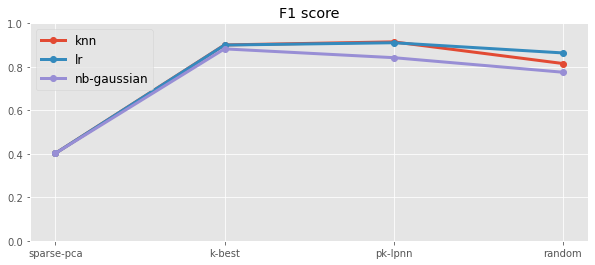

In [115]:
results_d = compute_results(results_folder)
plot_results(results_d, score="f1", add_svc=False)

N_z = 45



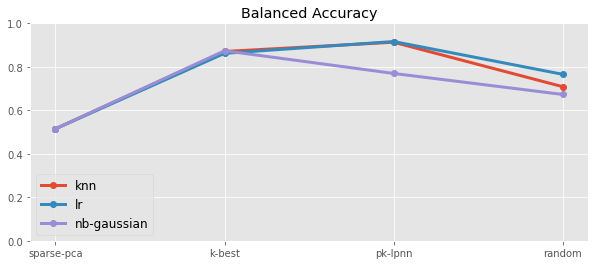

N_z = 89



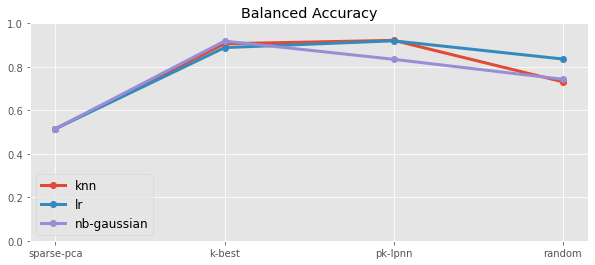

N_z = 178



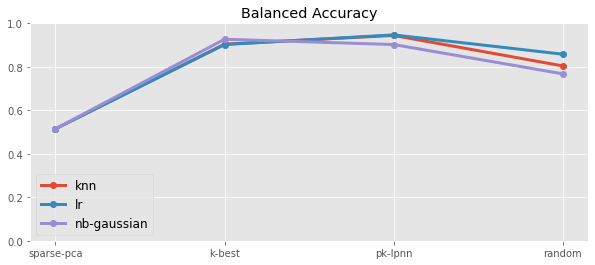

N_z = 356



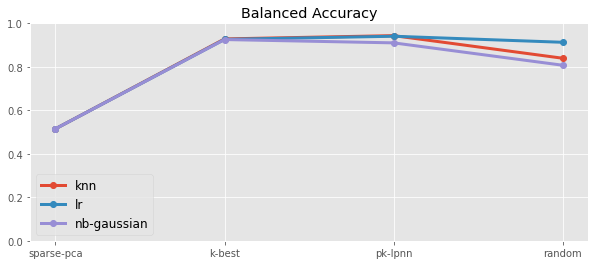

N_z = 712



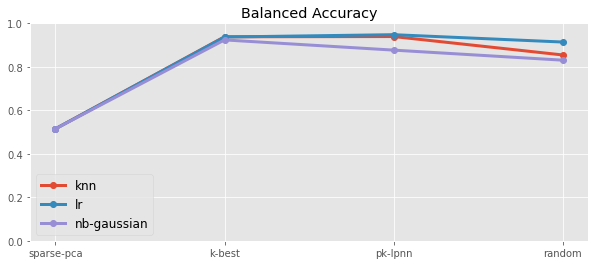

In [116]:
for nb_fts in [45, 89, 178, 356, 712]:

    print(f"N_z = {nb_fts}\n")
    
    results_folder = f"results/genetic_data/{nb_fts}" # separate folder for any nb_fts
    results_d = compute_results(results_folder)
    plot_results(results_d, score="b_acc", add_svc=False)

In [148]:
my_keys = [f"selected_fts_{nb_fts}", f"pca_fts_{nb_fts}", f"random_fts_{nb_fts}", f"full_fts_{nb_fts}"]
results_d = {k: results_d[k] for k in my_keys}

In [149]:
def addlabels(x,y):
    
    for i in range(len(x)):
        
        plt.text(i, 0.4, y[i], ha='center')

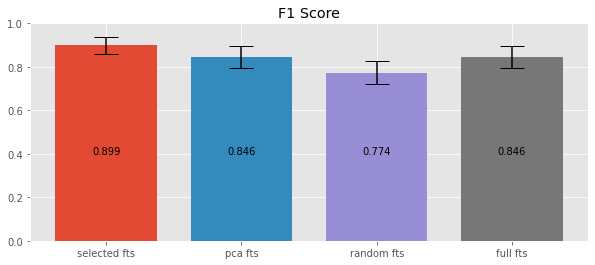

In [150]:
plt.figure(figsize=(10,4))

methods = []
means = []

for k, v in results_d.items():

    method = k.split("_")[0] + " " + k.split("_")[1]
    methods.append(method)
    values = np.array(v["f1"]).reshape(10,-1)
    
    mean = np.mean(np.mean(values, axis=1)) # mean of means
    means.append(np.round(mean, decimals=3))
    
    # std = np.std(np.mean(values, axis=1))   # std of means (old)
    # https://stats.stackexchange.com/questions/614162/standard-deviation-of-several-average%C2%B1sd
    ste = np.sqrt(np.sum(np.var(values, axis=1)) / (values.shape[0]**2)) # ste of 10 CV experiments 

    plt.bar(method, mean, yerr=ste, align='center', ecolor='black', capsize=12, width=0.75)

addlabels(methods, means)
plt.ylim([0, 1])

plt.title("F1 Score")
plt.savefig(os.path.join(results_folder, f'f1_{nb_fts}.pdf'), bbox_inches="tight")
plt.show()

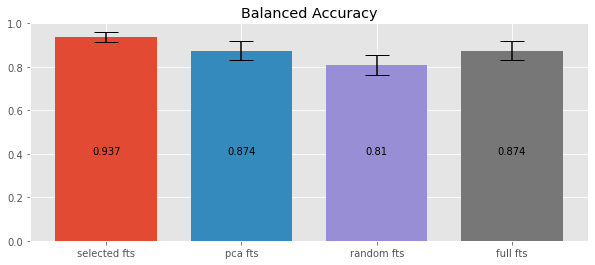

In [151]:
plt.figure(figsize=(10,4))

methods = []
means = []

for k, v in results_d.items():

    method = k.split("_")[0] + " " + k.split("_")[1]
    methods.append(method)
    values = np.array(v["b_acc"]).reshape(10,-1)
    
    mean = np.mean(np.mean(values, axis=1)) # mean of means
    means.append(np.round(mean, decimals=3))

    # std = np.std(np.mean(values, axis=1))   # std of means (old)
    # https://stats.stackexchange.com/questions/614162/standard-deviation-of-several-average%C2%B1sd
    ste = np.sqrt(np.sum(np.var(values, axis=1)) / (values.shape[0]**2)) # ste of 10 CV experiments 

    plt.bar(method, mean, yerr=ste, align='center', ecolor='black', capsize=12, width=0.75)

addlabels(methods, means)
plt.ylim([0, 1])

plt.title("Balanced Accuracy")
plt.savefig(os.path.join(results_folder, f'b_acc_{nb_fts}.pdf'), bbox_inches="tight")
plt.show()